In [88]:
import re
import pandas as pd
from typing import  Literal,List,Any
from langchain_core.tools import tool
from pydantic import BaseModel
from langchain_groq import ChatGroq
from langgraph.types import Command
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated
from langchain_core.prompts.chat import ChatPromptTemplate
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field, field_validator
from langchain_core.messages import HumanMessage,AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

In [89]:
import os

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY") 
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["GROQ_API_KEY"] = groq_api_key



In [239]:

groq_model = ChatGroq(
    # model="llama3-8b-8192",
      model="qwen-qwq-32b"
    # api_key=groq_api_key  # Secure API key usage
)


# from langchain_groq import ChatGroq
# llm=ChatGroq(model_name="Gemma2-9b-It")

# from langchain_google_genai import ChatGoogleGenerativeAI
# groq_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

#gemma-3-4b-it

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
gemini = ChatGoogleGenerativeAI(model="gemma-3-4b-it")
# gemini = ChatGoogleGenerativeAI(model="gemini-1.5-pro")


In [ ]:
gemini.invoke("hi").content

In [240]:
groq_model.invoke("hi")

AIMessage(content='\n<think>\nOkay, the user said "hi". I should respond in a friendly way. Maybe ask how I can assist them today. Keep it simple and open-ended so they feel comfortable to ask anything. Let me make sure there\'s no markdown here. Alright, that should work.\n</think>\n\nHi! 😊 How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 11, 'total_tokens': 80, 'completion_time': 0.160001104, 'prompt_time': 0.003189006, 'queue_time': 0.317866603, 'total_time': 0.16319011}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run-0e3e530c-d536-4729-9883-654e12a77595-0', usage_metadata={'input_tokens': 11, 'output_tokens': 69, 'total_tokens': 80})

In [92]:
class DateTimeModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$', v):  # Ensures 'DD-MM-YYYY HH:MM' format
            raise ValueError("The date should be in format 'DD-MM-YYYY HH:MM'")
        return v

In [93]:
class DateModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{2}-\d{2}-\d{4}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{2}-\d{2}-\d{4}$', v):  # Ensures DD-MM-YYYY format
            raise ValueError("The date must be in the format 'DD-MM-YYYY'")
        return v

In [94]:
class IdentificationNumberModel(BaseModel):
    id: int = Field(description="Identification number (7 or 8 digits long)")
    @field_validator("id")
    def check_format_id(cls, v):
        if not re.match(r'^\d{7,8}$', str(v)):  # Convert to string before matching
            raise ValueError("The ID number should be a 7 or 8-digit number")
        return v

In [95]:
@tool("check_availability_by_doctor", return_direct=True)
def check_availability_by_doctor(desired_date:DateModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Checking the database if we have availability for the specific doctor.
    The parameters should be mentioned by the user in the query
    """
    df = pd.read_csv(r"../data/doctor_availability.csv")
    
    # print(df)
    
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    
    rows = list(df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date)&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]['date_slot_time'])
    # print(rows)
    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'This availability for {desired_date.date}\n'
        output += "Available slots: " + ', '.join(rows)

    return output

In [96]:
# Example usage:
date_instance = DateModel(date="09-08-2024")
print(date_instance)

date='09-08-2024'


In [97]:
print(check_availability_by_doctor.invoke({"desired_date": date_instance, "doctor_name": "lisa brown"}))

This availability for 09-08-2024
Available slots: 08:00, 08:30, 09:00, 09:30, 10:00, 10:30, 11:00, 11:30, 12:00, 14:00, 14:30, 15:00, 15:30, 16:00, 16:30


In [98]:
@tool("check_availability_by_specialization", return_direct=True)
def check_availability_by_specialization(desired_date:DateModel, specialization:Literal["general_dentist", "cosmetic_dentist", "prosthodontist", "pediatric_dentist","emergency_dentist","oral_surgeon","orthodontist"]):
    """
    Checking the database if we have availability for the specific specialization.
    The parameters should be mentioned by the user in the query
    """
    #Dummy data
    df = pd.read_csv(r"../data/doctor_availability.csv")
    
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    rows = df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date) & (df['specialization'] == specialization) & (df['is_available'] == True)].groupby(['specialization', 'doctor_name'])['date_slot_time'].apply(list).reset_index(name='available_slots')

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        def convert_to_am_pm(time_str):
            # Split the time string into hours and minutes
            time_str = str(time_str)
            hours, minutes = map(int, time_str.split(":"))
            
            # Determine AM or PM
            period = "AM" if hours < 12 else "PM"
            
            # Convert hours to 12-hour format
            hours = hours % 12 or 12
            
            # Format the output
            return f"{hours}:{minutes:02d} {period}"
        
        output = f'This availability for {desired_date.date}\n'
        for row in rows.values:
            output += row[1] + ". Available slots: \n" + ', \n'.join([convert_to_am_pm(value)for value in row[2]])+'\n'

    return output

In [99]:
# Example usage:
date_instance = DateModel(date="03-09-2024")
print(date_instance)

date='03-09-2024'


In [100]:

print(check_availability_by_specialization.invoke({"desired_date": date_instance, "specialization": "orthodontist"}))

This availability for 03-09-2024
kevin anderson. Available slots: 
8:00 AM, 
8:30 AM, 
11:30 AM, 
12:00 PM, 
12:30 PM, 
1:00 PM, 
2:00 PM, 
2:30 PM, 
3:00 PM, 
3:30 PM, 
4:00 PM, 
4:30 PM



In [101]:
date_instance = DateModel(date="06-08-2024")
print(date_instance)
print(check_availability_by_specialization.invoke({"desired_date": date_instance, "specialization": "orthodontist"}))

date='06-08-2024'
No availability in the entire day


In [102]:
Old_Date_Time = DateTimeModel(date="05-08-2024 08:30")
Old_Date_Time

DateTimeModel(date='05-08-2024 08:30')

In [103]:
New_Date_Time = DateTimeModel(date="28-03-2024 14:30")
New_Date_Time

DateTimeModel(date='28-03-2024 14:30')

In [104]:
IDNumber = IdentificationNumberModel(id=1000082)
IDNumber

IdentificationNumberModel(id=1000082)

In [105]:
@tool("cancel_appointment", return_direct=True)
def cancel_appointment(date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Canceling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv(r"../data/doctor_availability.csv")
    case_to_remove = df[(df['date_slot'] == date.date)&(df['patient_to_attend'] == id_number.id)&(df['doctor_name'] == doctor_name)]
    if len(case_to_remove) == 0:
        return "You don´t have any appointment with that specifications"
    else:
        df.loc[(df['date_slot'] == date.date) & (df['patient_to_attend'] == id_number.id) & (df['doctor_name'] == doctor_name), ['is_available', 'patient_to_attend']] = [True, None]
        df.to_csv(f"../data/doctor_availability.csv", index = False)

        return "Successfully cancelled"

In [106]:
Date = DateTimeModel(date="05-08-2024 15:00")


IDNumber = IdentificationNumberModel(id=1000026)
IDNumber

IdentificationNumberModel(id=1000026)

In [107]:
print(cancel_appointment.invoke({"date": Date,"id_number":IDNumber,"doctor_name":"john doe"}))

Successfully cancelled


In [108]:
@tool("set_appointment", return_direct=True)
def set_appointment(desired_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Set appointment or slot with the doctor.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv(r"../data/doctor_availability.csv")
   
    from datetime import datetime
    def convert_datetime_format(dt_str):
        # Parse the input datetime string
        #dt = datetime.strptime(dt_str, "%Y-%m-%d %H:%M")
        dt = datetime.strptime(dt_str, "%d-%m-%Y %H:%M")
        
        # Format the output as 'DD-MM-YYYY H.M' (removing leading zero from hour only)
        # return dt.strftime("%d-%m-%Y %#H.%M")
        return dt.strftime("%d-%m-%Y %#H:%M")
    
    case = df[(df['date_slot'] == convert_datetime_format(desired_date.date))&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]
    # print(convert_datetime_format(desired_date.date))
    # print(df[df['date_slot'] == desired_date.date])

    if len(case) == 0:
        return "No available appointments for that particular case"
    else:
        df.loc[(df['date_slot'] == convert_datetime_format(desired_date.date))&(df['doctor_name'] == doctor_name) & (df['is_available'] == True), ['is_available','patient_to_attend']] = [False, id_number.id]
        df.to_csv(f"../data/doctor_availability.csv", index = False)

        return "Succesfully done"

In [109]:
Date = DateTimeModel(date="05-08-2024 15:00")

IDNumber = IdentificationNumberModel(id=1000026)
IDNumber

IdentificationNumberModel(id=1000026)

In [110]:
## Tools For Booking agent
@tool("reschedule_appointment", return_direct=True)
def reschedule_appointment(old_date:DateTimeModel, new_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Rescheduling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    #Dummy data
    df = pd.read_csv(r"../data/doctor_availability.csv")
    available_for_desired_date = df[(df['date_slot'] == new_date.date)&(df['is_available'] == True)&(df['doctor_name'] == doctor_name)]
    if len(available_for_desired_date) == 0:
        return "Not available slots in the desired period"
    else:
        cancel_appointment.invoke({'date':old_date, 'id_number':id_number, 'doctor_name':doctor_name})
        set_appointment.invoke({'desired_date':new_date, 'id_number': id_number, 'doctor_name': doctor_name})
        return "Successfully rescheduled for the desired time"

In [111]:
print(reschedule_appointment.invoke({"old_date": Old_Date_Time,"new_date": New_Date_Time,"id_number":IDNumber, "doctor_name": "kevin anderson"}))

Not available slots in the desired period


In [112]:
print(set_appointment.invoke({"desired_date":Date,"id_number":IDNumber,"doctor_name":"john doe"}))

Succesfully done


In [ ]:


class Router(TypedDict):
    """Decides which node to call next."""
    next: Literal["information_node","booking_node","FINISH"] = Field(..., description="Next worker")
    reasoning: str = Field(..., description="Internal reasoning")

In [113]:
# class AgentState(BaseModel):
#     messages: Annotated[list[Any], add_messages]
#     id_number: int
#     next:str
#     query: str
#     current_reasoning: str

class AgentState(TypedDict):
    messages: list[Any]
    id_number: int
    next: str = Field("supervisor", description="Next node to call")
    query: str = Field("", description="Original user query")
    current_reasoning: str = Field("", description="Model’s internal reasoning")

In [290]:
### workable

# 1. Define Pydantic schemas for routing
class Router(BaseModel):
    next: Literal["information_node", "booking_node", "confirmation_node","FINISH"] = Field(
        ..., description="Which specialized worker to call next"
    )
    reasoning: str = Field(..., description="Internal reasoning of the agent")

In [ ]:
# 2. Define the state model with defaults
class AgentState(BaseModel):
    messages: list[Any]
    id_number: int
    next: str = Field("supervisor", description="Next node to run")
    query: str = Field("", description="Original user query")
    current_reasoning: str = Field("", description="Last reasoning output")

In [291]:
type(Router)

pydantic._internal._model_construction.ModelMetaclass

In [292]:
type(AgentState)

typing_extensions._TypedDictMeta

In [293]:
members_dict = {'information_node':'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.',
                'booking_node':'specialized agent to only to book, cancel or reschedule appointment',
                'confirmation_node': "human-in-the-loop checkpoint. Whenever an agent asks a question requiring explicit user confirmation, the supervisor should route here. This node pauses execution, collects the user response, and returns control to supervisor."}

In [294]:
members_dict

{'information_node': 'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.',
 'booking_node': 'specialized agent to only to book, cancel or reschedule appointment',
 'confirmation_node': 'human-in-the-loop checkpoint. Whenever an agent asks a question requiring explicit user confirmation, the supervisor should route here. This node pauses execution, collects the user response, and returns control to supervisor.'}

In [295]:
options = list(members_dict.keys()) + ["FINISH"]

In [296]:
options

['information_node', 'booking_node', 'confirmation_node', 'FINISH']

In [297]:
worker_info = '\n\n'.join([f'WORKER: {member} \nDESCRIPTION: {description}' for member, description in members_dict.items()]) + '\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished'

In [298]:
print(worker_info)

WORKER: information_node 
DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: confirmation_node 
DESCRIPTION: human-in-the-loop checkpoint. Whenever an agent asks a question requiring explicit user confirmation, the supervisor should route here. This node pauses execution, collects the user response, and returns control to supervisor.

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished


In [299]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between following workers. "
    "### SPECIALIZED ASSISTANT WORKERS:\n"
    f"{worker_info}\n\n"
    # "Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. "
    # "If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, "
    # "delegate the task to the appropriate specialized workers. Given the following user request,"
    # " respond with the worker to act next. Each worker will perform a"
    # " task and respond with their results and status. When finished,"
    # " respond with FINISH."
    # "UTILIZE last conversation to assess if the conversation should end you answered the query, then route to FINISH "

"""
Your job is to choose the correct worker based on the user's request and the current context. Follow these rules strictly:

1. If the user asks about **doctor availability** or **does not specify a doctor's name**, route to `information_node`.

2. If the user wants to **book/reschedule/cancel** an appointment and has already provided their ID, doctor's name, and desired date/time, route to `booking_node`.

3. If availability has been checked and the user explicitly confirms a booking (e.g., 'yes', 'book it', 'confirm'), route to `booking_node`.

4. If the last agent response is a question intended for the user to answer (e.g., ends with '?'), route to `confirmation_node` before any further action.

5. If the user request has been fulfilled and no further action is needed, route to `FINISH`.

IMPORTANT:
- After `information_node` provides options, always pause at a confirmation question and route to `confirmation_node`.
- Do not loop indefinitely on `information_node` without user input.
- Treat questions as checkpoints to gather explicit user replies.

"""

# Your job: choose the single correct worker for the next step. **Output must be exactly one** of: `information_node`, `booking_node`, `confirmation_node`, or `FINISH`.

# Routing rules (in priority order):
# 1. If the last agent response ends with a question (`?`), select `confirmation_node`.
# 2. If user explicitly confirmed booking details (e.g., "yes", "confirm", "book it") and all info (ID, doctor name, date/time) exists, select `booking_node`.
# 3. If user requests booking/cancellation/reschedule and has provided ID, doctor, and date/time, select `booking_node`.
# 4. If user asks about availability or no doctor name provided, select `information_node`.
# 5. If conversation is complete, select `FINISH`.

# Respond with only the worker name—no extra text, no JSON.
# """
     
)

In [300]:
print(system_prompt)

You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT WORKERS:
WORKER: information_node 
DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: confirmation_node 
DESCRIPTION: human-in-the-loop checkpoint. Whenever an agent asks a question requiring explicit user confirmation, the supervisor should route here. This node pauses execution, collects the user response, and returns control to supervisor.

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished


Your job is to choose the correct worker based on the user's request and the current context. Follow these rules strictly:

1. If the user asks about **doctor availability** or **does not specify a doctor's name**, route to `information_node`.

2. If the user wants to **book/resch

In [301]:
# ================================
# 2. UTILITY FUNCTIONS
# ================================

def clean_messages(messages):
    """Remove duplicate messages and ensure proper formatting"""
    if not messages:
        return []
    
    cleaned = []
    seen_contents = set()
    
    for msg in messages:
        # Create a unique identifier based on content and type
        content_key = f"{msg.content[:100]}_{type(msg).__name__}"
        
        if content_key not in seen_contents:
            seen_contents.add(content_key)
            cleaned.append(msg)
    
    return cleaned


In [302]:
def supervisor_node(state: AgentState) -> Command[Literal['information_node', 'booking_node', 'confirmation_node', '__end__']]:
    
    print("**************************SUPERVISOR ENTRY****************************")
    print(f"Current state: {state}")
    print("="*70)
    
    # Clean messages to avoid duplicates
    clean_msgs = clean_messages(state.get("messages", []))
    
    # Build messages for the LLM
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"user's identification number is {state['id_number']}"},
    ] + clean_msgs
    
    # Get the current query
    query = ""
    if clean_msgs:
        # Get the last human message that's not about ID
        for msg in reversed(clean_msgs):
            if 1 and "identification number" not in msg.content:
                query = msg.content
                break
    
    print(f"Current query: {query}")
   
  
        
    # # Delegate routing entirely to the LLM Router
    try:

        print("llm calling...")
        response = groq_model.with_structured_output(Router).invoke(messages)
        goto = response.next
        
        print(f"🤖 LLM Decision: {goto} - Reasoning: {response.reasoning}")
        
        return Command(
            goto=goto if goto != "FINISH" else "__end__",
            update={
                "next": goto,
                "query": clean_msgs[-1].content if clean_msgs else "",
                "current_reasoning": response.reasoning,
                "messages": clean_msgs
            }
        )
        
    except Exception as e:
        print(f"❌ Error in supervisor: {e}")
        # Fallback logic
        return Command(
            goto="information_node",
            update={
                "next": "information_node",
                "current_reasoning": "Fallback to information node due to error",
                "messages": clean_msgs
            }
        )

In [303]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def information_node(state: AgentState) -> Command[Literal['supervisor']]:
    
    print("*****************INFORMATION NODE CALLED************")
    
    system_prompt = """You are an intelligent hospital information agent. Your job is to:
    
    1. Help users check doctor availability using the tools provided
    2. Provide clear information about available slots
    3. If user asks about booking AND you find available slots, ask if they want to proceed with booking
    4. Be polite and helpful
    
    Important:
    - Current year is 2024
    - When you find available slots, clearly state the doctor name and available times
    - If the exact time requested isn't available, suggest the closest alternatives
    - If user wants to book after seeing availability, confirm their choice
    - Use the tools available: check_availability_by_doctor, check_availability_by_specialization
    """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])
    
    # Create the agent with your existing tools
    information_agent = create_react_agent(
        model=groq_model,
        tools=[check_availability_by_doctor, check_availability_by_specialization],
        prompt=prompt
    )
    
    try:
        # Clean messages before processing
        clean_msgs = clean_messages(state["messages"])
        
        result = information_agent.invoke({"messages": clean_msgs})
        
        print(f"Information agent result: {result['messages'][-1].content}")

        print("next..")
        
        # Add the response to conversation
        new_message = AIMessage(
            content=result['messages'][-1].content, 
            name="information_node"
        )
        
        updated_messages = clean_msgs + [new_message]

        print("next..2")
        
        return Command(
            update={"messages": updated_messages}, 
            goto="supervisor"
        )
      
    except Exception as e:
        print(f"❌ Error in information_node: {e}")
        
        # Fallback response
        error_message = AIMessage(
            content="I'm having trouble checking availability right now. Please try again or contact support.",
            name="information_node"
        )
        
        return Command(
            update={"messages": state["messages"] + [error_message]}, 
            goto="supervisor"
        )


In [304]:
def booking_node(state: AgentState) -> Command[Literal['supervisor']]:
    
    print("*****************BOOKING NODE CALLED************")
    
    system_prompt = """You are a specialized booking agent for hospital appointments. Your job is to:
    
    1. Book, cancel, or reschedule appointments using the provided tools
    2. Extract date and time information from the conversation properly
    3. Use the exact format required by the tools (DD-MM-YYYY HH:MM or DD-MM-YYYY)
    4. Provide clear confirmation messages
    5. Handle any booking errors gracefully
    
    Important:
    - Current year is 2024
    - Always confirm the booking details (doctor, date, time) before proceeding
    - Use your tools: set_appointment, cancel_appointment, reschedule_appointment
    - If booking is successful, provide a clear confirmation message
    - Be polite and professional
    """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages")
    ])
    
    # Create agent with your existing booking tools
    booking_agent = create_react_agent(
        model=groq_model,
        tools=[set_appointment, cancel_appointment, reschedule_appointment],
        prompt=prompt
    )
    
    try:
        # Clean messages before processing
        clean_msgs = clean_messages(state["messages"])
        
        result = booking_agent.invoke({"messages": clean_msgs})
        
        print(f"Booking agent result: {result['messages'][-1].content}")
        
        # Add the response to conversation
        new_message = AIMessage(
            content=result['messages'][-1].content,
            name="booking_node"
        )
        
        updated_messages = clean_msgs + [new_message]
        
        return Command(
            update={"messages": updated_messages},
            goto="supervisor"
        )
        
    except Exception as e:
        print(f"❌ Error in booking_node: {e}")
        
        # Fallback response
        error_message = AIMessage(
            content="I'm having trouble processing the booking right now. Please try again or contact support.",
            name="booking_node"
        )
        
        return Command(
            update={"messages": state["messages"] + [error_message]},
            goto="supervisor"
        )

In [305]:
# 2. CONFIRMATION NODE (Human-in-the-loop)
# ================================

from langgraph.types import interrupt, Command

def confirmation_node(state: AgentState) -> Command[Literal['supervisor']]:
    """
    Pause the graph to get a human confirmation via LangGraph interrupt,
    then resume by injecting the user's response as a HumanMessage.
    """

    print("000000000000=-------inside pf confumation node------------")

    # Last question prompt
    last_ai: AIMessage = state['messages'][-1]
    # Use interrupt to get human input in production-friendly way
    response_text = interrupt(f"{last_ai.content}\nYour response:")

    # Append human response to conversation
    human_msg = HumanMessage(content=response_text)
    updated_msgs = state['messages'] + [human_msg]

    return Command(
        goto="supervisor",
        update={"messages": updated_msgs}
    )


In [203]:
def supervisor_node(state:AgentState) -> Command[Literal['information_node', 'booking_node','confirmation_node', '__end__']]:
    print("**************************below is my state right after entering****************************")
    
    print(state)
    print("---123---")
    # print(state['id_number'])
    # print("456")
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"user's identification number is {state['id_number']}"},
    ] + state["messages"]
    
    print("***********************this is my message*****************************************")
    print(messages)
    
    # # query = state['messages'][-1].content if state["messages"] else ""
    # query = ''
    # if len(state['messages']) == 1:
    #     query = state['messages'][0].content

    query = ""
    if len(state['messages']) >= 2 :
        query = state['messages'][-1].content if state["messages"] else ""
    else:
         last_user = None
         
    for msg in reversed(state["messages"]):
    
        if isinstance(msg, HumanMessage) and "identification number" not in msg.content:
            last_user = msg.content
            break
   
    if query == "":
        query = last_user or ""
    
    print("************below is my query********************")
    print(query or "NO query")


    print("before,")
      
    response = groq_model.with_structured_output(Router).invoke(messages)

    print("vbnm,")
    
    goto = response.next
    
    print("********************************this is my goto*************************")
    print(goto)
    
    print("********************************")
    # print(response["reasoning"])
    print("workinggg",response.reasoning)

        
    print("**************************below is my state****************************")
    print(state)

    new_history = state["messages"]
    # if this was a fresh user turn, tack it on:
    if query and (not state.get("query") == query):
        new_history = new_history + [HumanMessage(query)]

    
   # 5) Return with the full history preserved
    return Command(
        goto=goto if goto != "FINISH" else END,
        update={
            "next": goto,
            "query": query,
            "current_reasoning": response.reasoning,
            "messages": new_history
        }
    )

In [204]:

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def information_node(state:AgentState) -> Command[Literal['supervisor']]:
    
    print("*****************called information node************")
    
    # system_prompt = "You are specialized agent to provide information related to availability of doctors or any FAQs related to hospital based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
    
    system_prompt = """
You are an intelligent hospital agent. Your job is to help users check availability of doctors 
using the tools provided. Always be polite, and if the requested slot is unavailable, suggest alternatives.
Assume the current year is 2024.
"""

    system_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
    
    # information_agent = create_react_agent(model=groq_model,tools=[check_availability_by_doctor,check_availability_by_specialization] ,prompt=system_prompt)
    
    information_agent = create_react_agent(
        model=groq_model, 
        tools=[check_availability_by_doctor, check_availability_by_specialization],
        prompt=system_prompt
    )

    result = information_agent.invoke({"messages": state["messages"]})



    print("checking : ",result["messages"])


    state["messages"].append(AIMessage(content=result['messages'][-1].content, name="information_node"))
    
    return Command(update={"messages": state["messages"]}, goto="supervisor")

 # Check tool outputs (in final tool_call or parsed content)
    # last_response = result["messages"][-1].content.lower()

    # # 💡 Naive way to check if slot is unavailable in tool output or final message
    # if "not available" in last_response or "unavailable" in last_response:
    #     # ✅ Tell user what happened and exit
    #     state["messages"].append(AIMessage(content=(
    #         "Unfortunately, the requested slot seems to be unavailable. "
    #         "I've listed some available alternatives above. "
    #         "Let me know if you'd like to try booking another time."
    #     )))
    #     return Command(update={"messages": state["messages"]}, goto="supervisor")

    # # ✅ If response includes a confirmation (slot found), move to booking_node
    # elif "available" in last_response and "slot" in last_response:
    #     state["messages"].append(AIMessage(content="Great! The slot is available, proceeding to booking."))
    #     return Command(update={"messages": state["messages"]}, goto="supervisor")

    # # 🤷 Fallback — supervisor handles confusion
    # return Command(update={"messages": state["messages"]}, goto="supervisor")
    
    # return Command(
    #     update={
    #         "messages": state["messages"] + [
    #             AIMessage(content=result["messages"][-1].content, name="information_node")
                
    #             #HumanMessage(content=result["messages"][-1].content, name="information_node")
    #         ]
            

    #     },
    #     goto="supervisor",
    # )

In [205]:
def booking_node(state:AgentState) ->  Command[Literal['supervisor']]:
    
    print("*****************called booking node************")
    
    system_prompt = "You are specialized agent to set, cancel or reschedule appointment based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages")
    ])
    booking_agent = create_react_agent(model=groq_model,tools=[set_appointment,cancel_appointment,reschedule_appointment],prompt=prompt)

    result = booking_agent.invoke(state)
    
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="booking_node")
                #HumanMessage(content=result["messages"][-1].content, name="booking_node")
            ]
        },
        goto="supervisor",
    )

In [ ]:
# def booking_node(state: AgentState) -> Command[Literal["supervisor"]]:
#     print("*****************called booking node************")
#     system_message = """
# You are the booking agent. When the user asks to book you MUST:
# 1) Extract id_number (integer),
# 2) Extract doctor_name or specialization (string),
# 3) Extract desired_date in “YYYY-MM-DD HH:MM” (24h) format.
# If any piece is missing, ask a follow‑up. Once you have all three, reply exactly:
# CALL_FUNCTION
# and then generate the final set_appointment tool‑call.
# """

#     prompt = ChatPromptTemplate.from_messages([
#         ("system", system_message),
#         MessagesPlaceholder(variable_name="messages")
#     ])

#     booking_agent = create_react_agent(
#         model=groq_model,
#         tools=[set_appointment, cancel_appointment, reschedule_appointment],
#         prompt=prompt
#     )

#     # 1) confirm extraction
#     confirmation = booking_agent.invoke({
#         "messages": state["messages"] + [
#             HumanMessage(content=f"My ID number is {state['id_number']}."),
#             HumanMessage(content="If you have id_number, doctor_name, and desired_date, reply exactly: CALL_FUNCTION.")
#         ]
#     })


#     print(type(confirmation))
#     print("conformation :::",confirmation['messages'])
#     state["messages"].append(AIMessage(content=confirmation['messages'][-1].content))

#     # 2) only on CALL_FUNCTION call the tool
#     if "CALL_FUNCTION" in confirmation['messages'][-1].content:
#         print("INside of call function")

        
#         # result = booking_agent.invoke({"messages": state["messages"]})
#         result = booking_agent.invoke({
#     "messages": state["messages"] + [
#         HumanMessage(content=f"My ID number is {state['id_number']}."),
#         HumanMessage(content="If you have id_number, doctor_name, and desired_date, reply exactly: CALL_FUNCTION.")
#     ]
# })

#         state["messages"].append(AIMessage(content=result['messages'][-1].content))

#     return Command(update={"messages": state["messages"]}, goto="supervisor")


In [306]:
graph = StateGraph(AgentState)

In [307]:
graph.add_node("supervisor", supervisor_node)
graph.add_node("information_node", information_node)
graph.add_node("booking_node", booking_node)
graph.add_node("confirmation_node", confirmation_node)

In [308]:
# graph.add_edge("supervisor", "confirmation_node")



In [309]:
graph.add_edge(START, "supervisor")

In [310]:
app = graph.compile(checkpointer=checkpointer)

In [311]:
graph = app.get_graph()
print(graph)

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'supervisor': Node(id='supervisor', name='supervisor', data=supervisor(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'information_node': Node(id='information_node', name='information_node', data=information_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'booking_node': Node(id='booking_node', name='booking_node', data=booking_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'confirmation_node': Node(id='confirmation_node', name='confirmation_node', data=confirmation_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.L

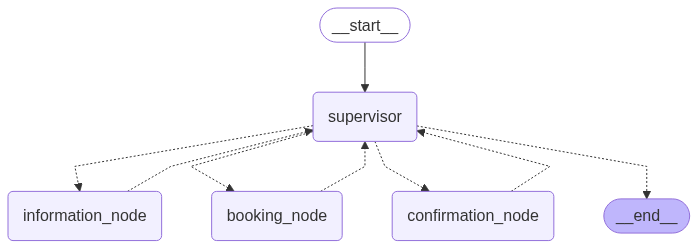

In [312]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [313]:
inputs = [
        HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 4 PM?')
    ]

In [314]:
state = {'messages': inputs,'id_number':10232303}

# class AgentState(BaseModel):
#     messages: Annotated[list[Any], add_messages]
#     id_number: int
#     next:str
#     query: str
#     current_reasoning: str

In [315]:
result = app.invoke(state)

**************************SUPERVISOR ENTRY****************************
Current state: {'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 4 PM?', additional_kwargs={}, response_metadata={})], 'id_number': 10232303}
Current query: can you check and make a booking if general dentist available on 8 August 2024 at 4 PM?
llm calling...
🤖 LLM Decision: information_node - Reasoning: User requested to check and book a general dentist appointment on 8 August 2024 at 4 PM. Since the doctor's name isn't specified, first need to check availability through information_node to confirm options before proceeding with booking.
*****************INFORMATION NODE CALLED************
Information agent result: This availability for 08-08-2024
emily johnson. Available slots: 
8:00 AM, 
8:30 AM, 
10:00 AM, 
10:30 AM, 
11:00 AM, 
11:30 AM, 
12:00 PM, 
12:30 PM, 
1:30 PM, 
2:30 PM, 
3:30 PM, 
4:30 PM
john doe. Available slots: 
8:00 AM, 
9:00 AM, 